<a href="https://colab.research.google.com/github/scrameri/Umweltbiologie/blob/master/Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial on Data Exploration


### Install packages if needed

In [0]:
need.pckg <- c("GGally","ggplot2","EnvStats") # needed for this script
if (any(!need.pckg %in% installed.packages())) {
  for (i in need.pckg[!need.pckg %in% installed.packages()]) {
    cat("installing", i, "...\n")
    install.packages(i)
  }
}

### Load libraries

In [0]:
library("GGally") # for ggpairs()
library("ggplot2") # for ggplot()
library("EnvStats") # for qqPlot()

***
### Read the data

In [0]:
morph <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Puzzle_ANOVA_LM.csv")

NOTE: the .csv file uses "," rather than ";" as field separators, which can cause troubles when opening the file in Excel on Mac. You can also save a version separated with ";", but you will then need to set `sep=";"`, because the default argument is `read.csv(file, sep = ',')`. Also have a look at the `read.csv2` function.



***
### Get an overview over the dataset
This dataset contains morphological measurements of eight populations of [*Dianthus carthusianorum*](https://www.infoflora.ch/de/flora/dianthus-carthusianorum.html) taken in Summer 2015 in Wallis (Switzerland). Populations were located in two classes of elevation (4 high, 4 low elevation).

A few facts about [*D. carthusianorum*](https://de.wikipedia.org/wiki/Kart%C3%A4usernelke)
- Karthäuser-Nelke in German, family Caryophyllaceae like *Silene*
- native to Middle Europe, in dry habitats from colline to alpine (introduced to N America) 
- [gynodioecious](https://en.wikipedia.org/wiki/Gynodioecy), meaning that there are female and hermaphroditic individuals
- perennial (or biennial), meaning that plants survive winter as rosettes or seeds
- insect-pollinated
- parasite: fungus [*Microbothryum*](https://fr.wikipedia.org/wiki/Microbotryum) *dianthorum* (anther smut fungus) that causes sterility and is transmitted by pollinators

A few facts about the dataset
- ID: individual ID
- Population: population ID
- Elevation: elevation class
- Date: measurement date
- Infection: whether a plant was [infected](https://upload.wikimedia.org/wikipedia/commons/e/ef/Microbotryum_dianthorum_Dianthus_sp._2019_07_18_05.jpg) or healthy
- Sex: whether a plant was hermaphroditic or female
- Stalk_height: mean stalk height per plant (mm)
- Stalk_count: number of stalks per plant
- Bud_count: number of buds per plant
- Flower_count: number of open flowers per plant
- Flower_diam: flower (corolla) diameter (mm)
- Petal and Sepal lengths and widths (mm)
- Rosette_diam1: diameter of first rosette (mm) - only recorded at high elevation
- Rosette_diam2: diameter of second rosette (mm) - only recorded at high elevation

The experimental design and measurements have been done by [Ursina Walther](https://peg.ethz.ch/people/person-detail.html?persid=158239) (a PhD student in our group). She was interested in studying the evolution of floral traits in this species, especially in relation to the interaction between the plants and their Microbothryum parasite.

Before starting any analysis, always check that the data was read in *correctly*.

In [23]:
str(morph) # lists all variables in the data.frame and their classes

'data.frame':	123 obs. of  17 variables:
 $ ID           : Factor w/ 123 levels "Fald_inf_1","Fald_inf_2",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Population   : Factor w/ 8 levels "Faldumalp","Gibidumsee",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Elevation    : Factor w/ 2 levels "high","low": 1 1 1 1 1 1 1 1 1 1 ...
 $ Date         : Factor w/ 7 levels "10.7.2015","4.8.2015",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Infection    : Factor w/ 2 levels "healthy","infected": 2 2 2 2 2 2 1 1 1 1 ...
 $ Sex          : Factor w/ 2 levels "female","hermaphroditic": 2 2 2 2 2 2 2 2 2 2 ...
 $ Stalk_height : num  176 112 173 161 165 ...
 $ Stalk_count  : int  2 5 3 3 1 2 7 16 9 3 ...
 $ Bud_count    : int  5 0 4 3 4 4 1 4 4 3 ...
 $ Flower_count : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Flower_diam  : num  14.1 14 12.8 13.3 14.8 13.2 17 14.6 17.3 11.2 ...
 $ Petal_length : num  5.6 5.3 6.3 4.8 6.5 7.2 8.2 7.7 7.7 4.4 ...
 $ Petal_width  : num  6.6 6.5 5.4 6.4 7.3 7.5 10.1 6 8.6 6.4 ...
 $ Sepal_length : num  12.9 12.6 11.9 13.2 14.

In [24]:
dim(morph) # gives both nrow() and ncol() of the dataset


[1] 123  17

In [25]:
summary(morph$Stalk_height) # gives a summary for one variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   28.2   136.4   212.0   256.7   380.0   670.0 

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
 Based on what you now know about the study and the data:
- what are the response variable(s)?
- what are the explanatory variable(s)?

***

### Plot the data
There are various plotting techniques to visualize data. Some people prefer the `R` base graphics, others learn the grammar of graphics implemented in [`ggplot2`](https://ggplot2.tidyverse.org/). For this practical, both approaches can be used. These are the basic functions for the most important plots, shown for `R` base graphics and `ggplot2` graphics:

Use **Scatterplots** to plot two numeric variables (classes `num` for continuous, or `int` for discrete data) against each other. Scatterplots can be more informative if different *symbols* or *colours* for an additional factor, or *sizes* or *transparency* for an additional numeric variable are used.

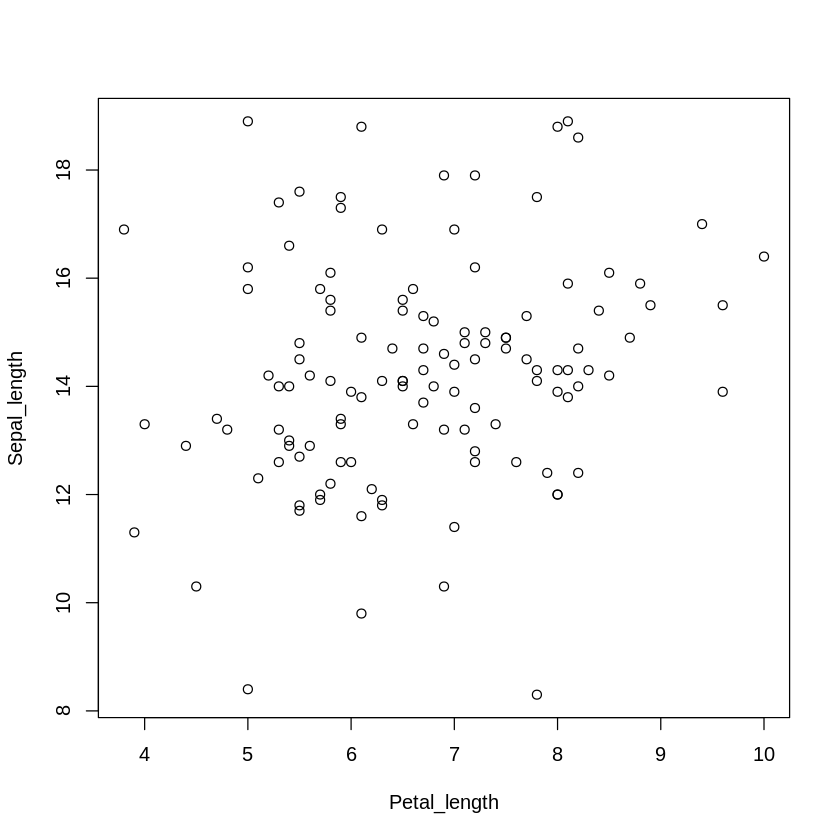

In [30]:
# base
plot(Sepal_length ~ Petal_length, data = morph)

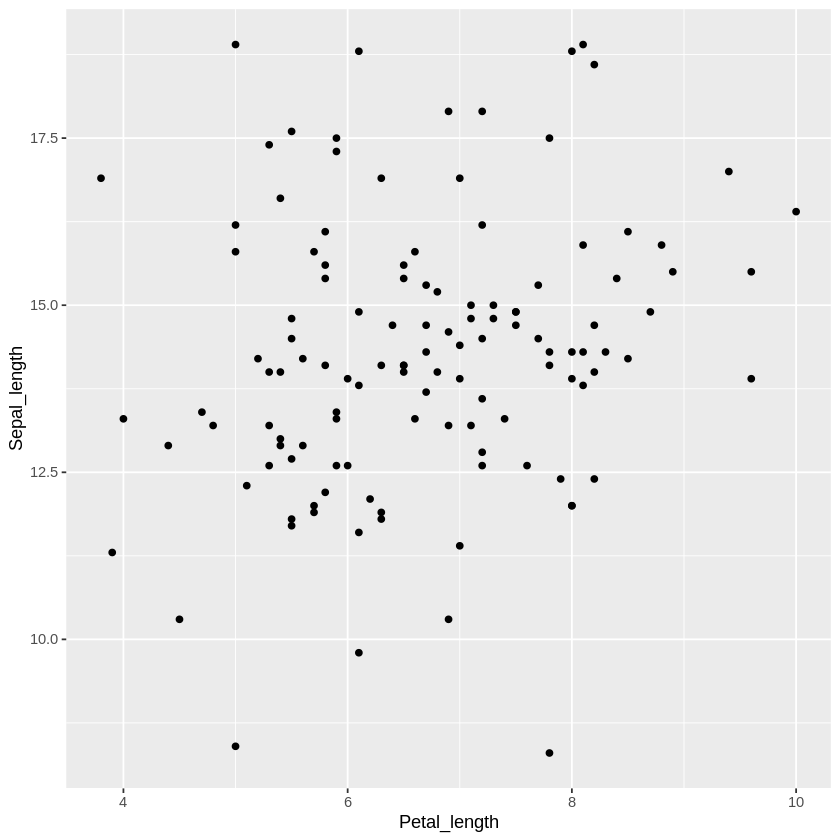

In [31]:
# ggplot2
ggplot(data = morph, aes(x = Petal_length, y = Sepal_length)) + geom_point()

Use **Boxplots** to plot a numeric variable against a categorical variable (class `factor`). Boxplots are summarizing the data. By default, the box is the *interquartile range* and contains 50% of the data points, while the whiskers extend to "the most extreme data point which is no more than 1.5 times the interquartile range from the box" (see cell 85). If you have less than eight data points per factor level, you might just aswell plot all the data points using `stripchart(Sepal_length ~ Elevation, data = morph, vertical = TRUE)`.

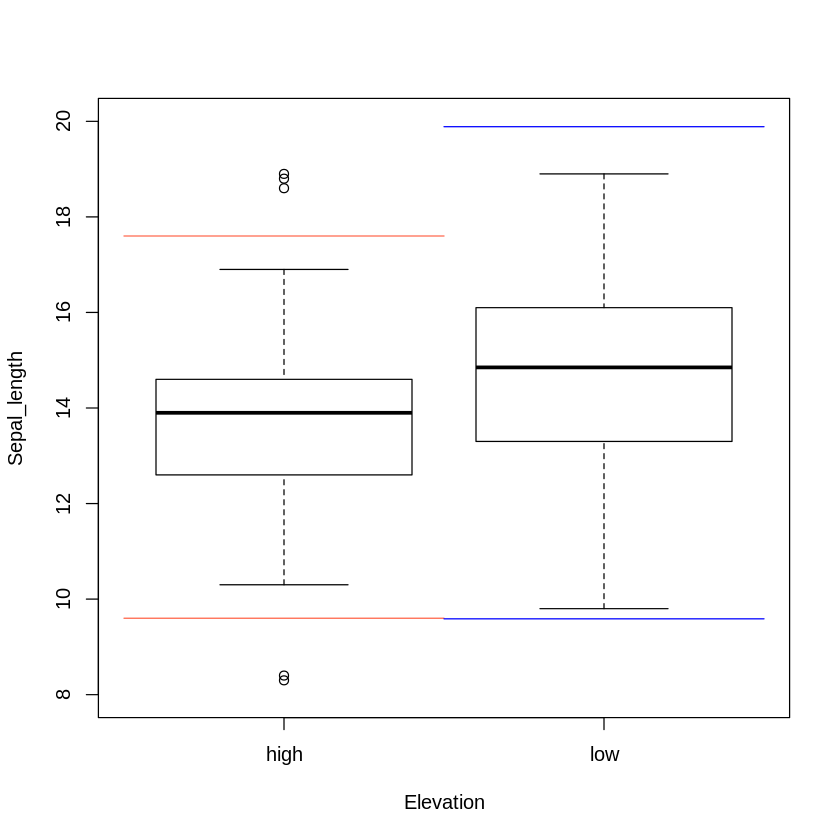

In [86]:
# base
boxplot(Sepal_length ~ Elevation, data = morph, ylim = c(8,20))

# understand interquartile range (iqr)
iqr1 <- quantile(morph$Sepal_length[morph$Elevation=="high"], c(0.25,0.75))
iqr2 <- quantile(morph$Sepal_length[morph$Elevation=="low"], c(0.25,0.75))

# whiskers are the most extreme data point not exceeding 1.5*iqr from the box
whisker1 <- iqr1 + c(-1.5,1.5)*diff(iqr1)
whisker2 <- iqr2 + c(-1.5,1.5)*diff(iqr2)

segments(0.5, whisker1, 1.5, whisker1, col = "tomato")
segments(1.5, whisker2, 2.5, whisker2, col = "blue")

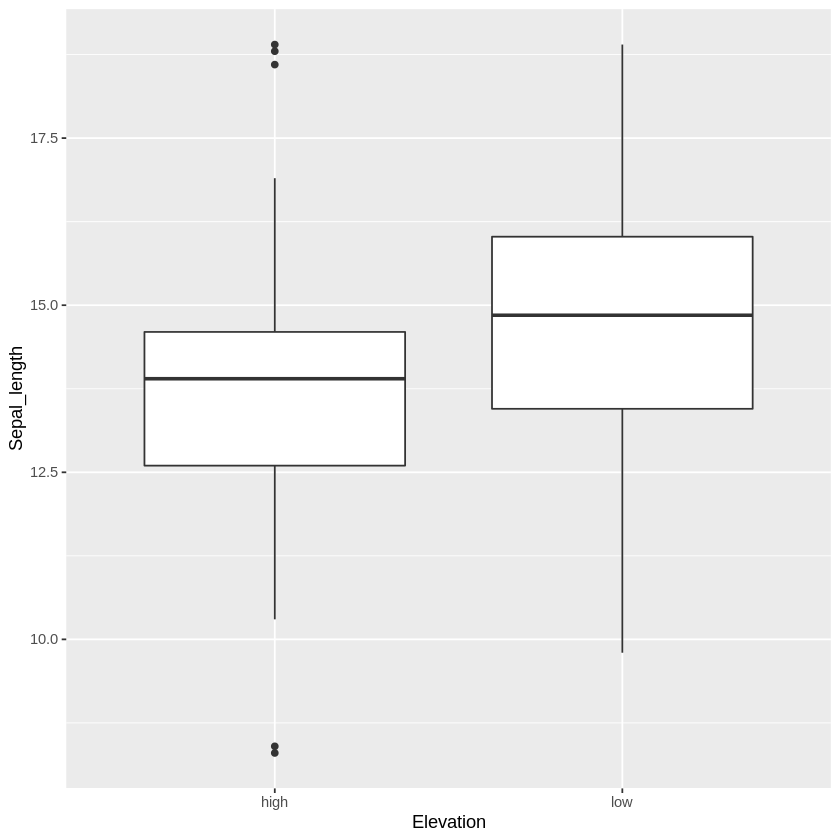

In [33]:
# ggplot2
ggplot(data = morph, aes(x = Elevation, y = Sepal_length)) + geom_boxplot()

Use **Histograms** to plot a variable's distribution. The `breaks` argument in `hist` and the `bins` argument in `geom_histogram` can be used to fine-tune the binning of values into histogram categories. Try and play around with it.

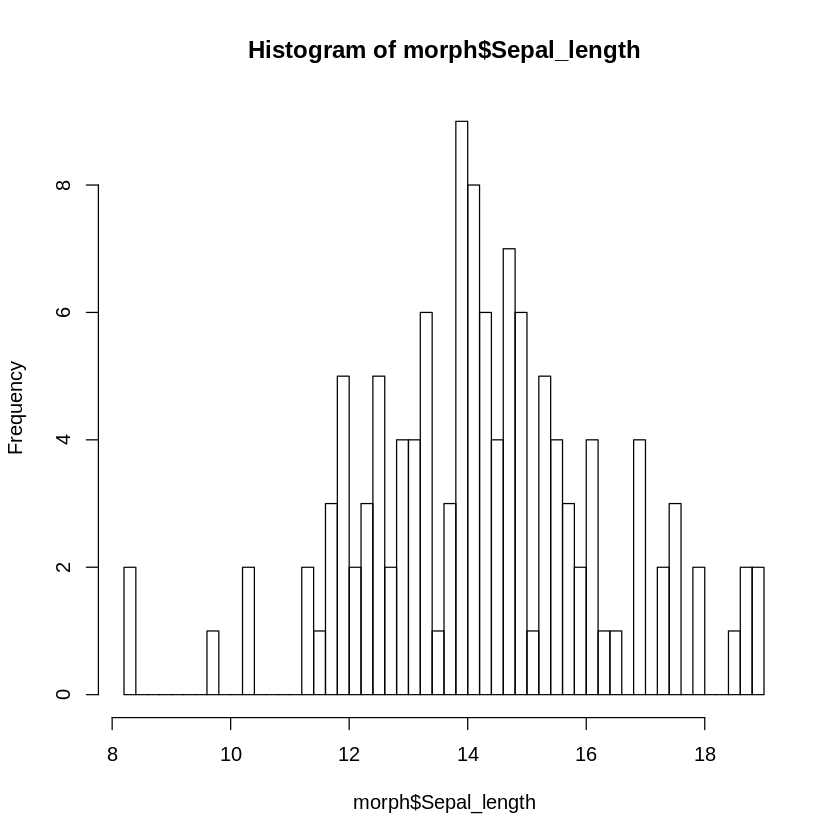

In [37]:
hist(morph$Sepal_length, breaks = 20)

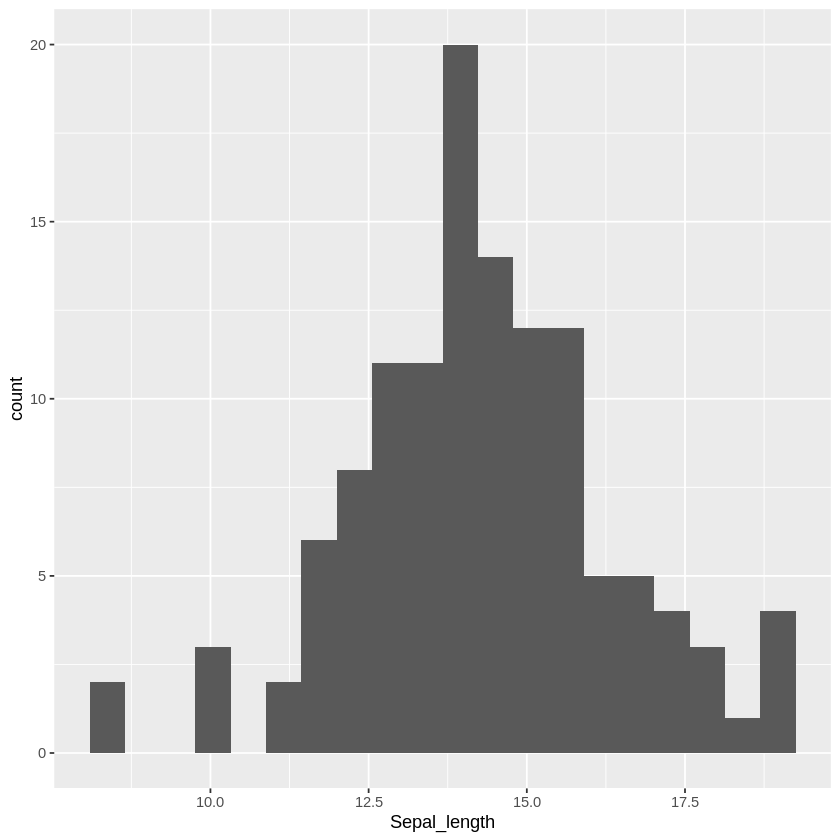

In [41]:
ggplot(data = morph, aes(x = Sepal_length)) + geom_histogram(bins = 20) 

Use **Barplots** to plot all values of a single variable or a table of counts.

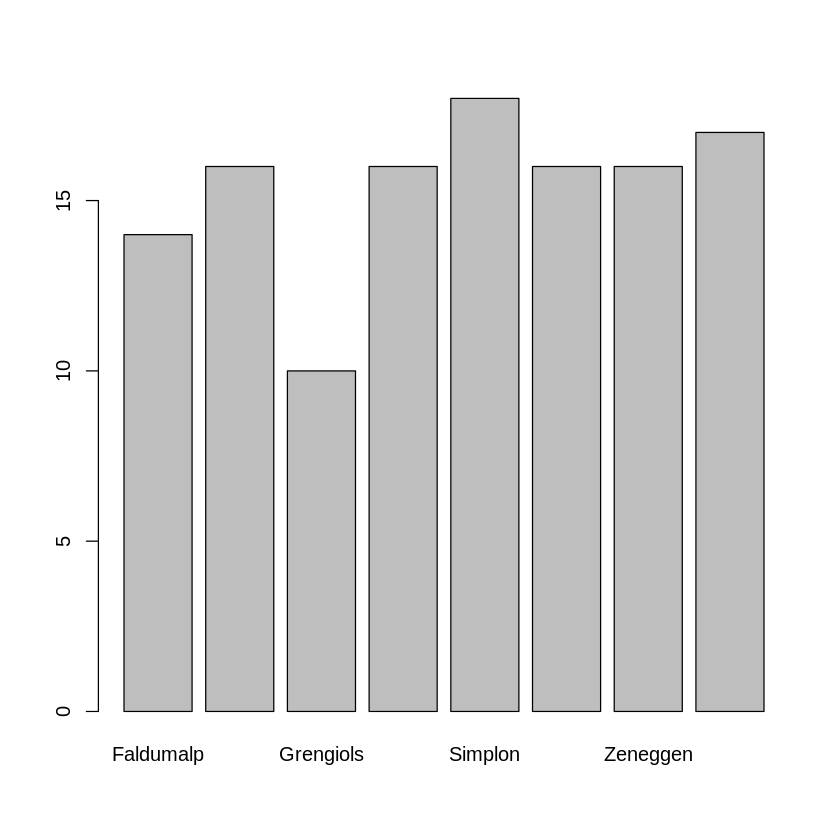

In [34]:
# base
barplot(table(morph$Population))

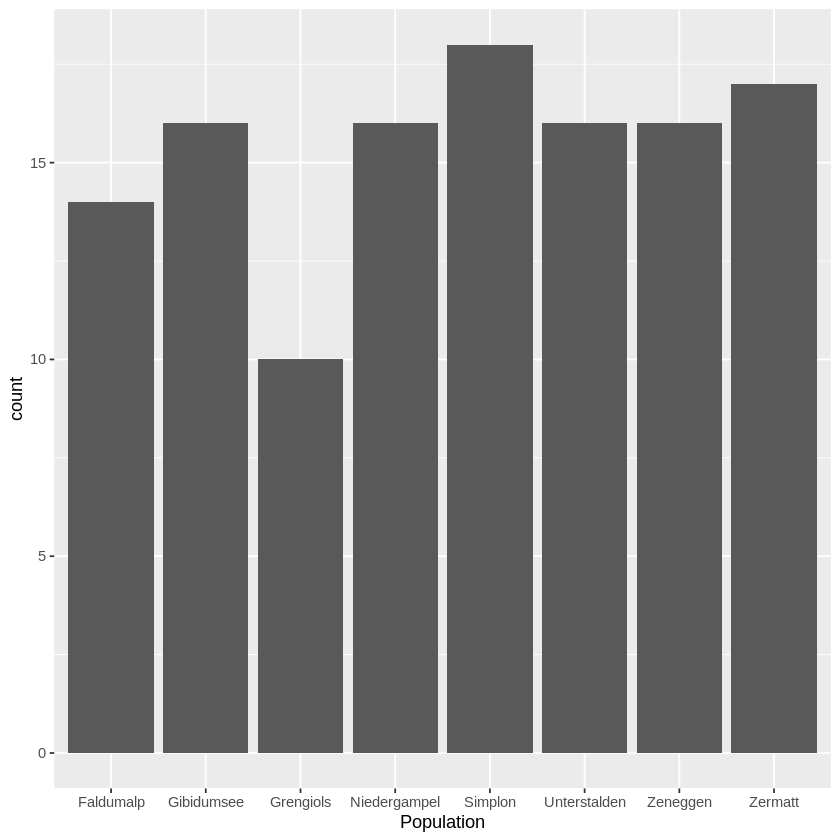

In [35]:
# ggplot2
ggplot(data = morph, aes(x = Population)) + geom_bar(stat = "count")

Use **Mosaic Plots** or **Stacked Barplots** to plot *contingency tables* of two categorical variables against each other. In a Mosaic Plot, the relative size of each mosaic is proportional to the number of observations with a given factor level combination. The stacked barplot slightly different, once shown as stacked *counts* and once as stacked *proportions*.

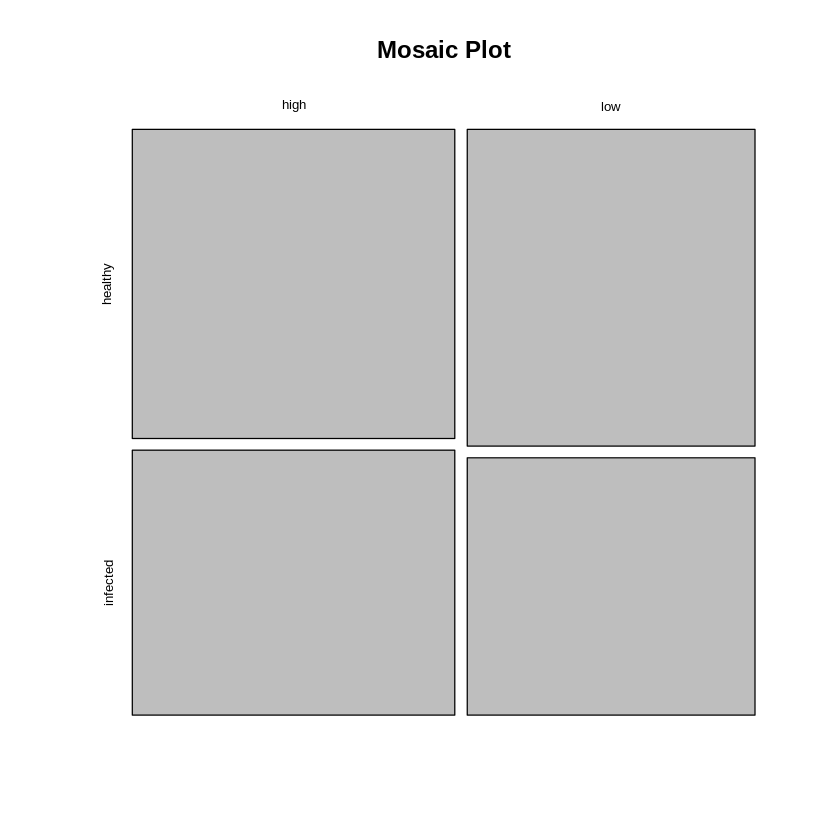

In [44]:
# base
mosaicplot(table(morph$Elevation,morph$Infection), main = "Mosaic Plot")

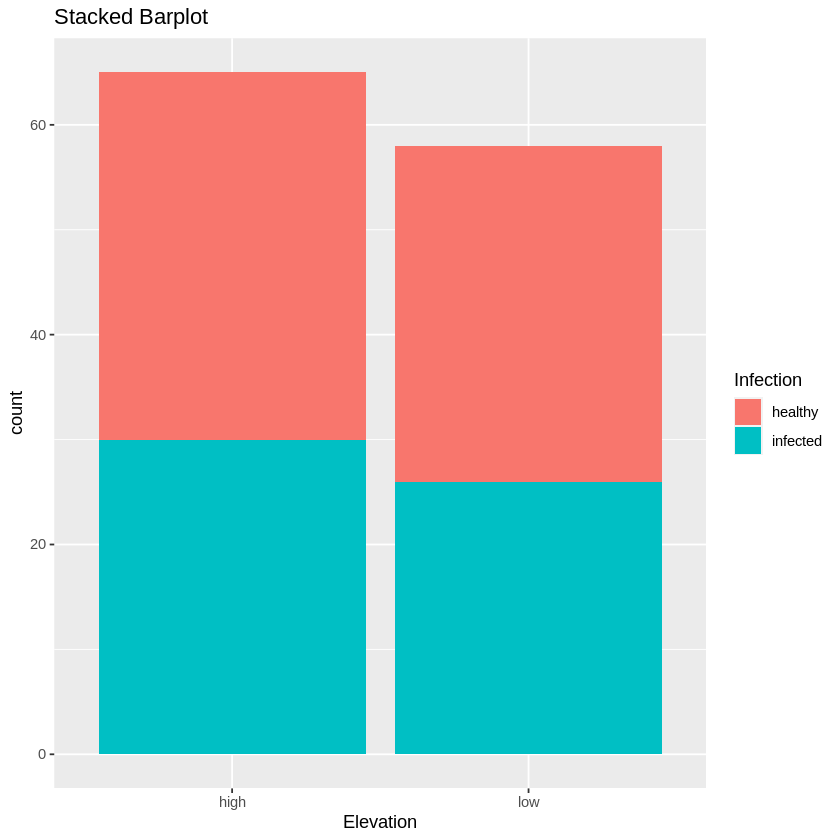

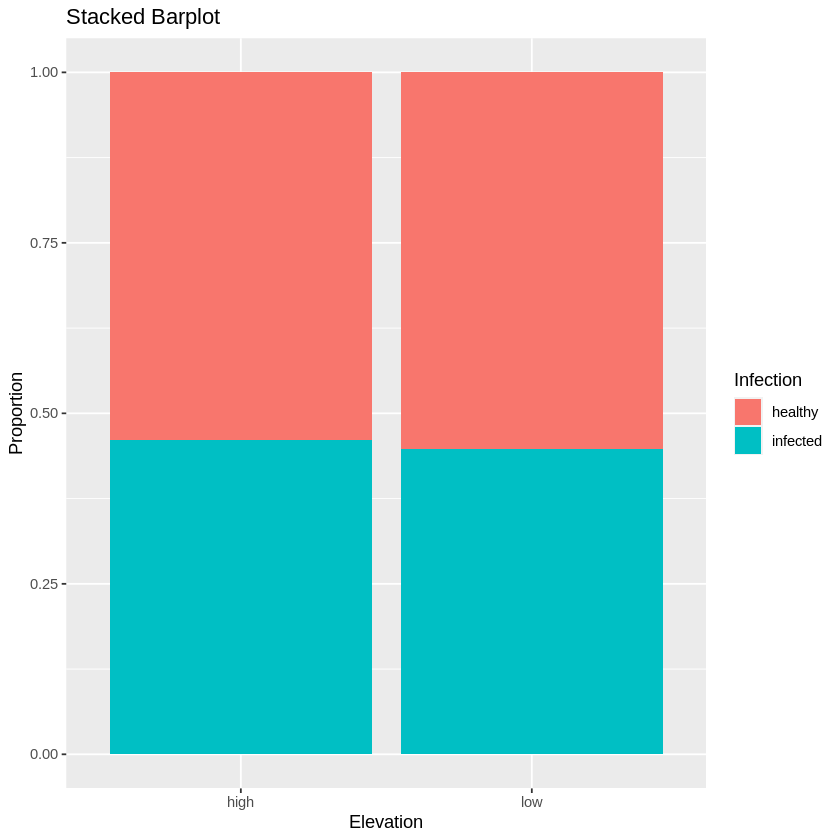

In [62]:
# ggplot2
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar() + 
  ggtitle("Stacked Barplot")
  
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar(position = "fill") + labs(y = "Proportion") +
  ggtitle("Stacked Barplot")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you produce a plot of `Petal_length ~ Sepal_length` with points color-coded for `Infection` and size proportional to `Petal_length`?


In [0]:
# Make your plot here

***
### Use regular expressions
Given that we have 17 variables, plotting all of them against each other would be tedious. For datasets with a moderate number of variables, you can use the `ggpairs` function from the [*GGally*](https://cran.r-project.org/web/packages/GGally/index.html) package to get a graphical overview over many variables at once with a single line of code. The function produces all possible pairwise plots, minimizes redundancy and takes care of factors and numerical variables automatically.

With 17 variables, plotting all against all would lead to too many (289) plots on a single page. Let us therefore subset the variables. You can use `grep` and [**regular expressions**](https://regex101.com/) to find the indices of certain variable names, this often saves code.

In [45]:
# this returns the index of variable names *starting* with 'Flower' (^ specifies the *start*)
grep(pattern = "^Flower_", x = names(morph))

[1] 10 11

In [97]:
# this returns the index of variable names *ending* with either 'length' or 'width' ($ specifies the *end*, | is a logial <or>)
grep(pattern = "length$|width$", x = names(morph)) 


[1] 12 13 14 15

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you identify the indices of columns with variables of *fertile* structures (buds, flowers) using a regular expression?

In [96]:
# Create your regular expression here
names(morph)
grep(pattern = "XXX", x = names(morph))

[1] "ID"            "Population"    "Elevation"     "Date"         
 [5] "Infection"     "Sex"           "Stalk_height"  "Stalk_count"  
 [9] "Bud_count"     "Flower_count"  "Flower_diam"   "Petal_length" 
[13] "Petal_width"   "Sepal_length"  "Sepal_width"   "Rosette_diam1"
[17] "Rosette_diam2"

integer(0)

***
### Generate all pairwise plots

In [47]:
# if you put a line in (), the returned value will be printed to the console (saves a print() call)
(vars.fertile <- names(morph)[grep(pattern = "^Flower|^Bud|^Petal|^Sepal", x = names(morph))])
(vars.sterile <- names(morph)[grep(pattern = "^Stalk|^Rosette", x = names(morph))])

[1] "Bud_count"    "Flower_count" "Flower_diam"  "Petal_length" "Petal_width" 
[6] "Sepal_length" "Sepal_width"

[1] "Stalk_height"  "Stalk_count"   "Rosette_diam1" "Rosette_diam2"

The `ggpairs` function prepares the pairwise plots as `gg` class objects. These can then be printed to the plotting device, or saved to a PDF file by enclosing the print commands between the `pdf` and `graphics.off` functions.

It is more reproducible (and therefore more scientific) to save plots with such code rather than by manually exporting a plot from R Studio. The specified `height` and `width` also prevents the saved plot to be smaller or larger depending on your device size.

In [0]:
pairs.fertile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.fertile))
pairs.sterile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.sterile))

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing

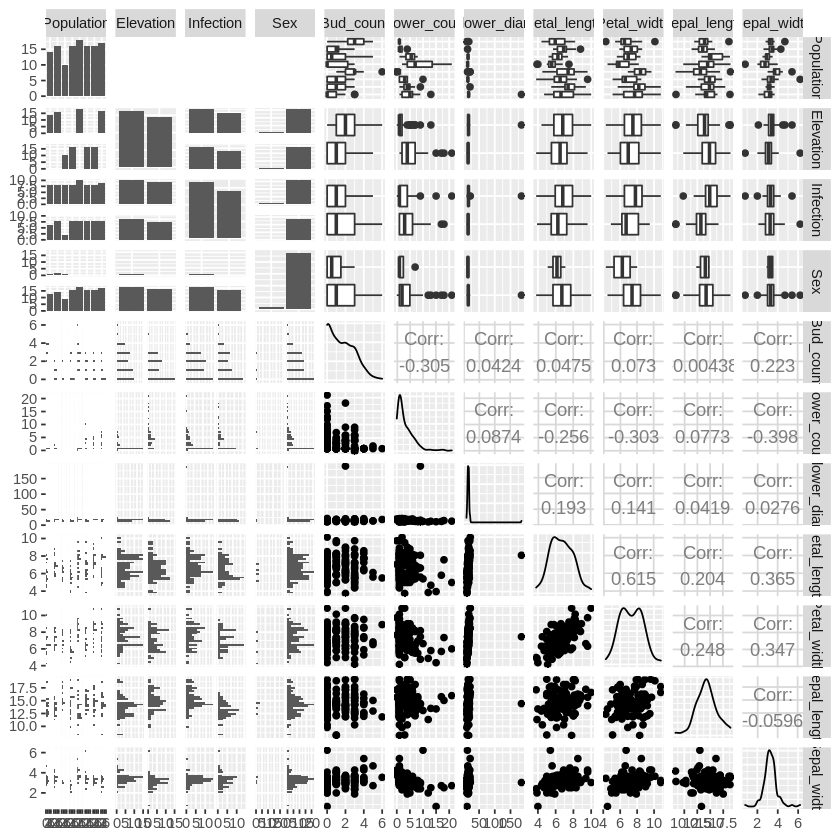

In [88]:
#pdf("Pairsplots.pdf", height = 15, width = 15)
#pairs.sterile # or print(pairs.sterile)
pairs.fertile # or print(pairs.fertile)
#graphics.off()

Does everything look all right?




***
### Transparent data fixes
If there are obvious data errors, do not manually change the original data. Rather think carefully what the issue might be, and if you can be sure enough, make the data changes in the analysis script, such that fixes become **transparent** and **reproducible**. If you cannot reconstruct what happened with an impossible data value, you should set it to `NA` or remove the entire data row in the analysis script.

In [91]:
morph$Flower_diam[morph$Flower_diam > 100] # Dianthus with 185 mm flower diameter is impossible
morph$Flower_diam[morph$Flower_diam > 100] <- morph$Flower_diam[morph$Flower_diam > 100]/10 # if you are sure it is a comma-error
# morph$Flower_diamesser[morph$Flower_diamesser > 100] <- NA # if you cannot be sure what happened


numeric(0)

***

### Check the distribution of your variables
Knowing the distribution of your variables is important, especially if you want to create models of them that make certain assumptions on distributions. You have already seen that the **histogram** is a good visualization of a variable's distribution because deviations from a normal distribution become intuitively apparent.

Let us look at `Stalk_count`, which is a count variable and therefore by definition bound by zero on the left, and unbounded on the right. Such *right-skewed* distributions are not normally distributed.

But which statistical distribution is best at describing your data if not a normal distribution? Knowing this would help you to define an appropriate error distribution in a generalized linear model. Simulations can help you to compare your data against data from a specific statistical distribution. The `R` package [*EnvStats*](https://cran.r-project.org/web/packages/EnvStats/index.html) allows for simulation of different probability distributions and comparison of these against your data in so-called **QQ Plots** (Quantile-Quantile plots).

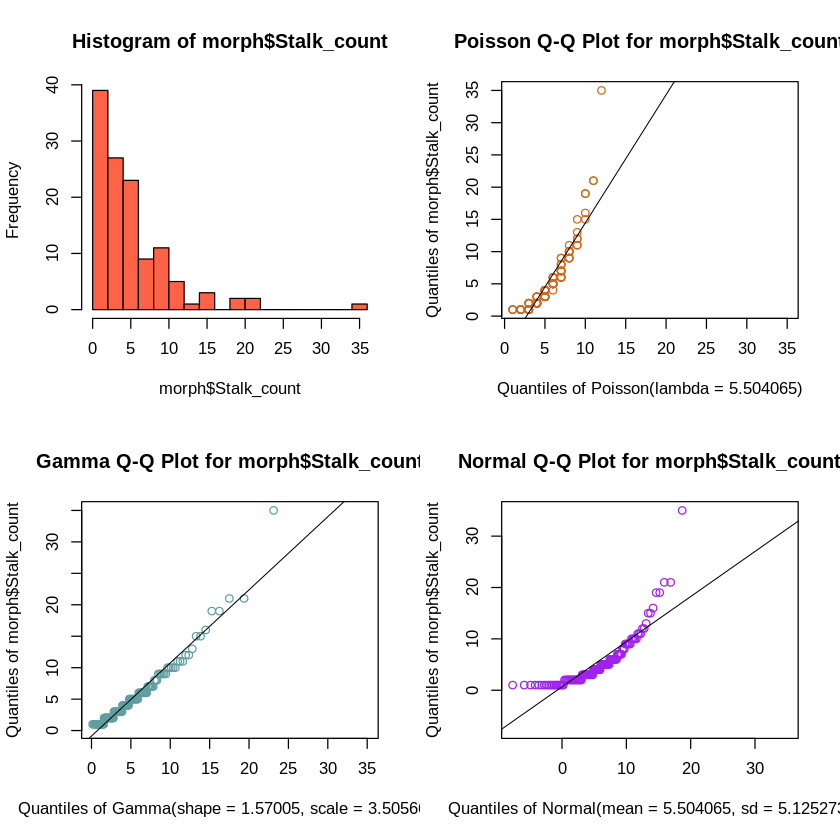

In [55]:
par(mfrow=c(2,2))
hist(morph$Stalk_count, breaks = 20, col = "tomato")
qqPlot(morph$Stalk_count, distribution = "pois", estimate.params = TRUE, add.line = TRUE, points.col = "chocolate")
qqPlot(morph$Stalk_count, distribution = "gamma", estimate.params = TRUE, add.line = TRUE, points.col = "cadetblue")
qqPlot(morph$Stalk_count, distribution = "norm", estimate.params = TRUE, add.line = TRUE, points.col = "purple")
par(mfrow=c(1,1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Which probability distribution is best at describing ```Stalk_count```? 
- What does this mean for an ANOVA model ```Stalk_count ~ Elevation``` fitted to this data?

***

## Analysis of Variance and Linear Models

### The relationship between t-test, ANOVA and linear models

**Analysis of Variance (ANOVA)** using `aov` and (generalized) **linear models** using `lm`or `glm` are closely related to each other and differ mainly in *intent* of analysis and default *presentation* of results. If you read the aov help page, you will see that `aov` actually calls `lm`, so both rely on the same [least squares])(https://en.wikipedia.org/wiki/Least_squares) method.


You can think of ANOVA and linear models as extensions of a two-sample [**t-test**](https://en.wikipedia.org/wiki/Student%27s_t-test) that allow for tests of more factors or covariates at once. Remember that the two-sample t-test allows to test the difference in a dependent variable (a.k.a. **response** variable, measure variable, Y variable) between two levels of one factor (a.k.a. **predictor** variable, independent variable, X variable). An example two-sample t-test is the test for difference in human height (the response variable) between two sexes (the predictor variable). 

Let us start with a **one-sample t-test**:

In [100]:
t.test(morph$Sepal_length, mu = 0)


	One Sample t-test

data:  morph$Sepal_length
t = 77.368, df = 122, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 13.91985 14.65088
sample estimates:
mean of x 
 14.28537 


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the test result?

This test can also be accomplished using `lm`:

In [101]:
summary(lm(Sepal_length ~ 1, data = morph))


Call:
lm(formula = Sepal_length ~ 1, data = morph)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9854 -1.3354 -0.0854  1.1646  4.6146 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  14.2854     0.1846   77.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.048 on 122 degrees of freedom


Let us now extend this to a **two-sample t-test** (one sample at low and one at high elevation):

In [109]:
# complicated syntax, showing the two samples (sepal lengths at high and low elevation)
# t.test(morph$Sepal_length[morph$Elevation == "high"], morph$Sepal_length[morph$Elevation == "low"], data = morph, mu = 0)

# shorter and more elegant formula notation 
t.test(Sepal_length ~ Elevation, data = morph, mu = 0)


	Welch Two Sample t-test

data:  Sepal_length by Elevation
t = -2.8931, df = 119.46, p-value = 0.004535
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.7502608 -0.3279355
sample estimates:
mean in group high  mean in group low 
          13.79538           14.83448 


Again, the same test can be accomplished using `lm` or `aov`. A `summary` on `aov` will give you the **ANOVA table**, while `lm` will give you **effect size** estimates.

In [110]:
cat("**ANOVA table**\n")
summary(aov(Sepal_length ~ Elevation, data = morph))

cat("\n\n**Effect size estimates**\n")
summary(lm(Sepal_length ~ Elevation, data = morph))

**ANOVA table**


             Df Sum Sq Mean Sq F value  Pr(>F)   
Elevation     1   33.1   33.09   8.369 0.00453 **
Residuals   121  478.5    3.95                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



**Effect size estimates**



Call:
lm(formula = Sepal_length ~ Elevation, data = morph)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4954 -1.2954  0.0655  0.9655  5.1046 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   13.7954     0.2467  55.930  < 2e-16 ***
Elevationlow   1.0391     0.3592   2.893  0.00453 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.989 on 121 degrees of freedom
Multiple R-squared:  0.06469,	Adjusted R-squared:  0.05696 
F-statistic: 8.369 on 1 and 121 DF,  p-value: 0.004529


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the estimated effect size of Elevation?
- How do you interpret the Elevation effect estimate intuitively?


***

### One-way ANOVA and simple linear models

The **one-way ANOVA** allows for comparing more then just two groups (i.e. one treatment factor can have more than two levels). 

Tests with more than 2 levels in a predictor variable can have different intents: 

1. test for an *overall* effect of a factor such as Population on calyx length
2. test for an effect of a *specific* factor level, for instance a treatment relative to a *control*, including effect size estimates.

If your goal is 1., then you can use `aov`:

In [111]:
summary(aov(Sepal_length ~ Population, data = morph))

             Df Sum Sq Mean Sq F value Pr(>F)  
Population    7   55.8   7.976   2.013 0.0593 .
Residuals   115  455.8   3.963                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

If your goal is 2., then you can use `lm`. Note that a `summary` on `lm` does not give you an answer to the hypothesis "Population has an effect on Sepal_length", while a `summary` on `aov` does.

In [113]:
summary(lm(Sepal_length ~ Population, data = morph))


Call:
lm(formula = Sepal_length ~ Population, data = morph)

Residuals:
   Min     1Q Median     3Q    Max 
-5.900 -1.194  0.000  1.206  5.550 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             14.0000     0.5321  26.313   <2e-16 ***
PopulationGibidumsee    -0.4187     0.7285  -0.575    0.567    
PopulationGrengiols      1.8000     0.8243   2.184    0.031 *  
PopulationNiedergampel   0.3938     0.7285   0.540    0.590    
PopulationSimplon       -0.6500     0.7094  -0.916    0.361    
PopulationUnterstalden   0.9188     0.7285   1.261    0.210    
PopulationZeneggen       0.5875     0.7285   0.806    0.422    
PopulationZermatt        0.3000     0.7185   0.418    0.677    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.991 on 115 degrees of freedom
Multiple R-squared:  0.1091,	Adjusted R-squared:  0.05491 
F-statistic: 2.013 on 7 and 115 DF,  p-value: 0.0593


***

### Multi-way ANOVA and multiple linear regression
There are many extensions to one-way ANOVA and simple linear models. In `R`, you can use the same functions `aov` and `lm` (or `glm`) and provide them with a more complex model. 

The **Factorial ANOVA** extends the one-way ANOVA to test >1 predictors (each with two or more levels), including interactions.

The **mathematical model** for two predictors without interaction is as follows:
* Y = β<sub>0</sub> + β<sub>1</sub>\*X<sub>1</sub> + β<sub>2</sub>\*X<sub>2</sub> + E ; E ~ norm(0, sd) i.i.d.

Y, X<sub>1</sub>, and X<sub>2</sub> are given. The model fitting consists of estimating distributions for β<sub>0</sub>, β<sub>1</sub> and β<sub>2</sub>
while minimizing the error term E (approximated by the so-called residuals).

The corresponding **model formula** in `R` is as follows (no need to specify intercept and error term):

* `Y ~ X1 + X2`

Three preditors, the second nested in the first:
* `Y ~ X1/X2 + X3`

Three predictors, two of them interacting:
* `Y ~ X1 + X2 + X1:X2 + X3`
* `Y ~ (X1 + X2)^2 + X3`

Three predictors, include all two-way interactions:
* `Y ~ X1 + X2 + X1:X2 + X1:X3 + X2:X3`
* `Y ~ (X1 + X2 + X3)^2`

Three predictors, include all three-way interactions (rarely used):
* `Y ~ (X1 + X2 + X3)^3`


***

### ANCOVA and GLMs

The **ANCOVA** (Analysis of Covariance) allows for the mixed use of numerical and categorical predictors. **Generalized linear models** (GLMs) extend ANCOVA by allowing for non-normal error distribution (logistic regression, poisson regression, ...):

Logistic regression
* E ~ Binom(k|p,n) i.i.d

Poisson regression
* E ~ Poisson(lambda) i.i.d.

***
### Interactions
Interactions between predictor (explanatory) variables can be present, and including them in a model can *greatly* improve the model fit and hence the reliability of test results.

An **interaction** occurs if the effect of variable A on the response Y *depends* on variable B.

Example:
You want to model reaction time as Y ~ A + B

* Y = time needed to start breaking after an obstacle appears on the street
* A = amount of coffee drunk 
* B = amount of whisky drunk 

A has a negative effect on reaction time (i.e., more coffee, less reaction time), while B has a positive effect on reaction time (i.e, more whisky, more reaction time).

You can increase coffee consumption to shorten reaction time, but this effect will depend on the amount of whisky drunk. That is, the amount of coffee *interacts* with the amount of whisky.


`R` implements some methods to visualize potential interactions. The idea is to visualize the mean (or other summary) value of the `response` Y at different levels of an explanatory variable of interest (`x.factor`), depending on the level of another and potentially interacting explanatory factor (`trace.factor`).

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to test the effect of `Infection` and `Altitude` on `Petal_length`. Before you fit any model, make sure to plot the data to get a better feeling for it.

In [0]:
## Make a clever plot(s) that shows Petal_legnth, Infection and Altitude

`Petal_length` appears to be lower in some infected individuals, but that does not seem to be the case in low `Elevation` habitats. That is, the effect of `Infection` on `Petal_length` appears to *depend* on `Elevation`. Or in other words: `Infection` and `Elevation` likely *interact*.

The following plot visualizes potential interactions. If the lines cross, the factors strongly interact and you would need to test for the interaction term in any model of `Petal_Length`.

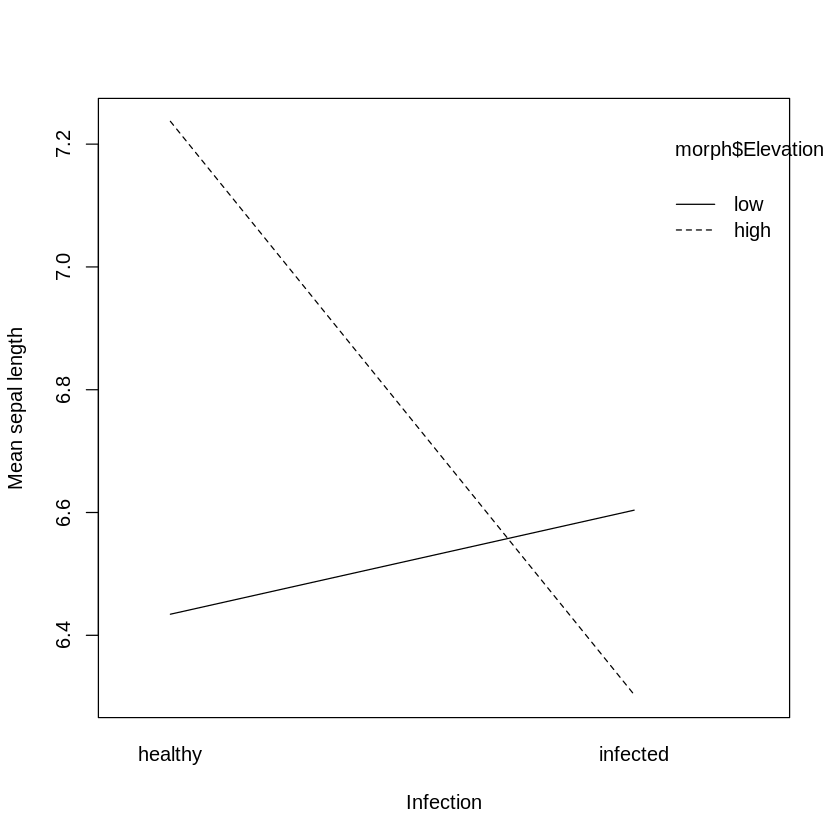

In [116]:
interaction.plot(x.factor = morph$Infection, trace.factor = morph$Elevation, response = morph$Petal_length, 
                 fun = mean, xlab = "Infection", ylab = "Mean sepal length")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to formally test for the effect of `Infection` and `Elevation` (including their potential interaction) on `Petal_length`, and estimate the effect sizes.
* which function do you use (`aov` or `lm`)?
* which formula do you use?
* what are the test results?

In [117]:
## Create your model here
summary(mod1 <- "X")


Call:
lm(formula = Petal_length ~ Infection * Elevation, data = morph)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.83714 -0.93576 -0.03714  0.86424  2.99615 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      7.2371     0.2081  34.771  < 2e-16 ***
Infectioninfected               -0.9338     0.3064  -3.048  0.00284 ** 
Elevationlow                    -0.8028     0.3012  -2.665  0.00876 ** 
Infectioninfected:Elevationlow   1.1033     0.4467   2.470  0.01494 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.231 on 119 degrees of freedom
Multiple R-squared:  0.08694,	Adjusted R-squared:  0.06392 
F-statistic: 3.777 on 3 and 119 DF,  p-value: 0.01246


***

### Check model assumptions via Residual Analysis
Up to now, we have just blindly executed `summary` on `aov` and `lm` fits and interpreted the test results. In practice, this is **not sufficient**.

In order to validate the model, we need to check that the model assumptions are met, or at least not grossly violated.

ANOVA and linear regression models both make the following **assumptions**:
  
* [**Normality:**](https://en.wikipedia.org/wiki/Normal_distribution) For any fixed value of X, Y is *normally distributed*. This implies that the *residuals* are normally distributed. However, it does not mean that all variables have to be normally distributed (not even within groups).
* [**Homoscedasticity:**](https://en.wikipedia.org/wiki/Homoscedasticity) The *residual variance* is *constant* (the same for any value of X)
* [**Independence:**](https://en.wikipedia.org/wiki/Independence_(probability_theory)) Observations are *independent* of each other (i.e. one measurement is not influenced by another)

If one or more of these assumptions are **violated**, you **cannot have trust in your test results** and in any conclusions drawn from them.

You can check most assumptions by applying the generic `plot` function on your model fit. Since this will give you **four diagnostic plots**, it is best to divide the plotting device into four panels using `par`.

The first plot (**Tukey-Anscombe Plot**) is good to check for the assumption of *constant variance* of the residuals. This assumption is violated if there is a funnel-shape ur U-shaped distribution.

The second plot (**Normal Q-Q Plot**) is good to check for the assumption of *normality* of the residuals. If the points lie more or less on the diagonal, they follow a normal distribution. If you don't trust your eye, you can also formally test the null hypothesis of normality using a **Shapiro-Wilk normality test** using `shapiro.test` on the model residuals. If that test turns out significant (p < 0.05), it means that the null hypothesis of normality is rejected, and hence that the residuals are not normally distributed.

The **Scale-Location Plot** is similar to the Tukey-Anscombe Plot but plots the square-root of absolute residuals, which allows to see other aspects of residual variance. 

The **Leverage Plot** is good to identify outliers (points that lie outside of Cook's distance). Such outliers could have a strong effect on the model fit and test results and should be investigated further if present.



	Shapiro-Wilk normality test

data:  mod1$resid
W = 0.98906, p-value = 0.4358


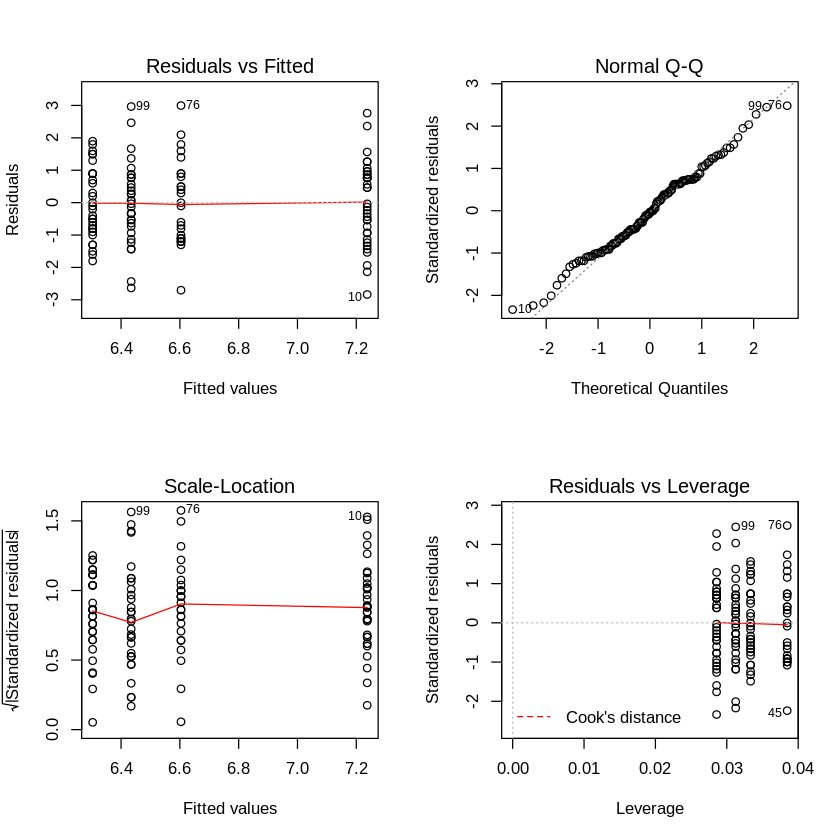

In [120]:
par(mfrow = c(2,2))
plot(mod1)
par(mfrow = c(1,1))

shapiro.test(mod1$resid)

Independence of measurements can be assessed by plotting a response variable's values in their order of measurements, or with a **Serial Correlation Plot** using the `acf` function (assuming the the order of measurements of `Petal_length` in the table corresponds to the order of measurements taken on each `Date`. If the autocorrelation function ACF is within the blue dotted lines, the measurements are not significantly autocorrelated (or dependent).

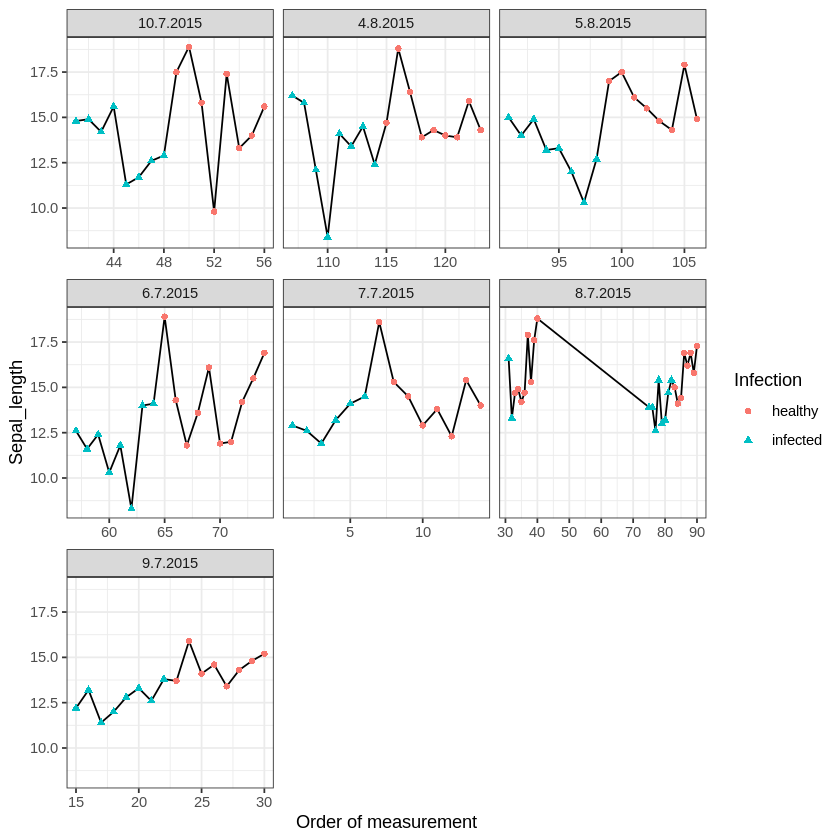

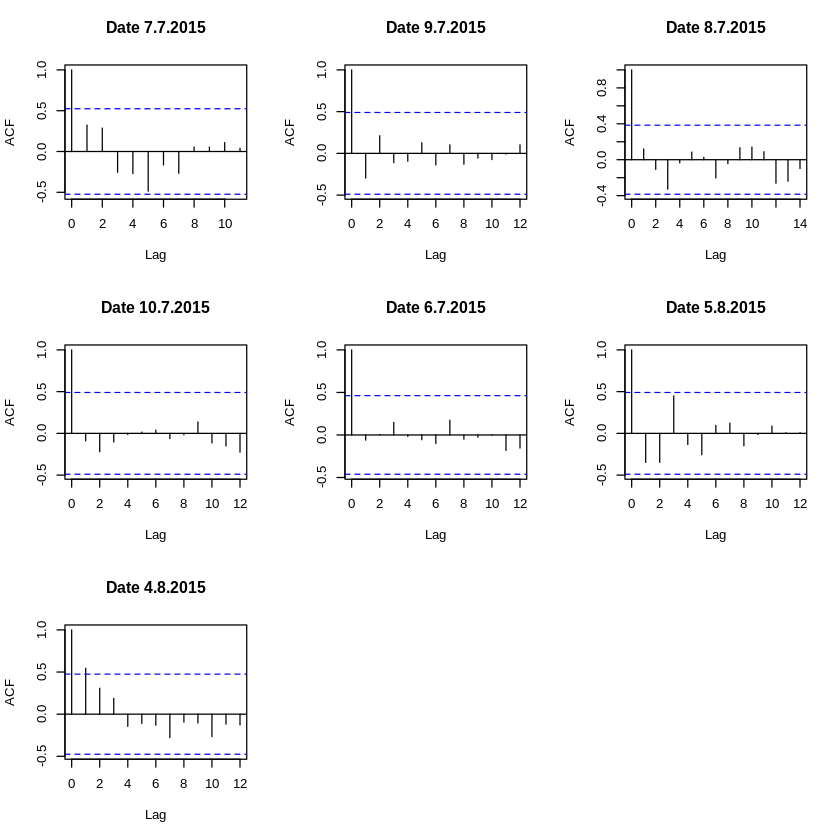

In [124]:
ggplot(morph, aes(seq_along(Sepal_length), Sepal_length)) + 
  geom_line() + geom_point(aes(color = Infection, shape = Infection)) +
  labs(x = "Order of measurement") +
  facet_wrap(~Date, scales = "free_x") + 
  theme_bw()

par(mfrow = c(3,3))
for (date in unique(morph$Date)) {
  acf(morph$Petal_length[morph$Date == date], main = paste("Date", date))
}
par(mfrow = c(1,1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Are the assumptions of normality, constant variance and independence of the residuals met?


***
### Variable transformations
Apart from interaction effects, transformations of the resonse Y or the numerical predictors X often help to improve model fit, at the expense of interpretability of the fitted model parameters (estimated effect sizes). There are the following commonly used **first-aid transformations**.

- for *positive counts*:               `X <- sqrt(X)`
- for *positive continuous variables*: `X <- log(X)`
- for *fractions* [0,1]:               `X <- asin(sqr(X))`

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Now try to apply a transformation to the response.
* Does the model fit improve?

In [0]:
## Create your model here
mod2 <- "X"

***
### Compare nested models
Complex models are *less parsimonious* (more parameters need to be estimated). If a complex model can be replaced by a simpler model with an equally good fit, one would always **prefer the simpler model**. 

You can formally test two **nested** models (i.e. fitted to the same data, one model with one or more additional model terms) using the `anova` function. If the F test turns out significant, the **larger / complex** model (in our case, the model including the interaction term) is a **better** fit to the data, and should thus be preferred over the smaller / simpler model.


In [129]:
anova(aov(Petal_length ~ Infection * Elevation, data = morph), aov(Petal_length ~ Infection + Elevation, data = morph))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,119,180.4332,NA,NA,NA,NA
2,120,189.6815,-1,-9.248309,6.099481,0.01494049


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Which model(s) meet the assumptions?
* Which model would you choose?